In [1]:
from src.utils.myOptimization import (
    solveGroupProblem, closed_form_group_alpha, AlphaFairnesstorch,
    solveIndProblem, solve_closed_form, solve_coupled_group_alpha, compute_coupled_group_obj
)
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.fairness.cal_fair_penalty import atkinson_loss, mean_abs_dev, compute_fairness_grad,mean_abs_dev, compute_group_accuracy_parity

import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import pandas as pd

from src.utils.features import get_all_features
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Define Alpha & Q

In [2]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 2,
    "beta": 2.5,
    "Q": 2000,
    "epochs": 100,
    "lambdas": 1.0,
    "lr": 0.01
}

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "w") as f:
    json.dump(params, f, indent=4)

import json

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "r") as f:
    params = json.load(f)

n_sample = params["n_sample"]
alpha    = params["alpha"]
beta     = params["beta"]
Q        = params["Q"]
epochs   = params["epochs"]
lambdas  = params["lambdas"]
lr       = params["lr"]


In [3]:
df = pd.read_csv('/Users/dennis/Downloads/2024-fall/research/Fairness-Decision-Focused-Loss/Organized-FDFL/src/data/data.csv')
df = df.sample(n=n_sample,random_state=42)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values) * 10
cost = np.maximum(cost, 0.1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
true_benefit = np.array(df['benefit'].values) * 100
true_benefit = np.maximum(true_benefit, 0.1) 

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values)

## Prediction Model

In [4]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

In [5]:

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(true_benefit, dtype=torch.float32)
# Split the data, including cost and race
X_train, X_test, y_train, y_test, race_train, race_test, cost_train, cost_test = train_test_split(
    X_tensor, y_tensor, race, torch.tensor(cost, dtype=torch.float32), test_size=0.5, random_state=42
)


## Training Function

In [ ]:
# ------------------------------------------------------------------
#  Fairness helpers
# ------------------------------------------------------------------
# compute_individual_fairness(pred, true, race)
# compute_group_accuracy_parity(pred, true, race)
# solveGroupProblem(benefit, cost, race, alpha, Q)
# alpha_fairness_group_utilities(benefit, d, race, alpha)

# ------------------------------------------------------------------
#  TRAIN + EVALUATE FUNCTION
# ------------------------------------------------------------------
def train_fair_model_logged(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, beta, Q,
        lambda_fair=0.0, fairness_type="none", group=True,
        num_epochs=30, lr=1e-2, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cpu")):
    """
    Train a fairness–aware predictor and log train-loss, test-MSE,
    test-normalised-regret, and test-fairness each epoch.
    """
    # -------------------------- type-check -----------------------------
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test  = torch.tensor(X_test, dtype=torch.float32)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.float32)
        y_test  = torch.tensor(y_test, dtype=torch.float32)
    if not isinstance(race_train, torch.Tensor):
        race_train = torch.tensor(race_train, dtype=torch.float32)
        race_test  = torch.tensor(race_test, dtype=torch.float32)
    # -------------------------- dataloaders ------------------------
    train_ds = TensorDataset(X_train.to(device), y_train.to(device), race_train.to(device))
    if batch_size is None:
        batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # -------------------------- model & opt ------------------------
    model  = model_class(input_dim, dropout_rate=dropout_rate).to(device)
    optim  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit   = nn.MSELoss()

    # -------------------------- logs -------------------------------
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []

    # -------------------------- training loop ----------------------
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for x_b, y_b, r_b in train_loader:
            pred_b = model(x_b).squeeze()
            mse    = crit(pred_b, y_b)

            # fairness penalty
            if fairness_type == "acc_parity":
                fair_pen = compute_group_accuracy_parity(pred_b, y_b, r_b)
            elif fairness_type == "atkinson":
                fair_pen = atkinson_loss(pred_b, y_b, race=race_train, 
                            mode = 'between' if group else 'individual') 
            elif fairness_type == "mad":
                fair_pen = mean_abs_dev(pred_b, y_b, race=race_train, 
                            mode = 'between' if group else 'individual')                     
            else:
                fair_pen = torch.tensor(0.0, device=device)

            loss = mse + lambda_fair * fair_pen
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item() * x_b.size(0)

        loss_log.append(epoch_loss / len(train_ds))

        # ----------------- evaluation on the held-out set ----------
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test.to(device)).squeeze().cpu()
        mse_val = ((pred_test - y_test).pow(2)).mean().item()
        mse_log.append(mse_val)

        # ensure positivity for optimisation step
        pred_b_np  = pred_test.numpy().reshape(-1, 1)
        pred_b_np  = np.maximum(pred_b_np, 1e-1)

        # regret on test set
        race_np    = race_test.numpy()
        if group:
            pred_b_np = pred_test.numpy().reshape(-1)
            y_test_np = y_test.numpy().reshape(-1) if isinstance(y_test, torch.Tensor) else np.array(y_test).reshape(-1)
            cost_test_np = cost_test.numpy().reshape(-1) if isinstance(cost_test, torch.Tensor) else np.array(cost_test).reshape(-1)
            race_np = race_test.numpy().reshape(-1) if isinstance(race_test, torch.Tensor) else np.array(race_test).reshape(-1)

            sol_pred = solve_coupled_group_alpha(pred_b_np, cost_test_np, race_np, alpha=alpha, Q=Q, beta=beta)
            sol_true = solve_coupled_group_alpha(y_test_np, cost_test_np, race_np, alpha=alpha, Q=Q, beta=beta)
            true_obj = compute_coupled_group_obj(sol_true, y_test_np, race_np, alpha=alpha, beta=beta)
            pred_obj = compute_coupled_group_obj(sol_pred, y_test_np, race_np, alpha=alpha, beta=beta)

        else:
            b_pred = pred_b_np.flatten()
            b_true = y_test.flatten()
            c_vec = cost_test.flatten()
            ones_array = np.ones_like(b_pred)

            # solve the individual problem
            sol_pred_i, _ = solve_closed_form(ones_array ,b_pred, c_vec, alpha=alpha, Q=Q)
            sol_true_i, _ = solve_closed_form(ones_array,b_true, c_vec, alpha=alpha, Q=Q)

            # build torch‐tensors of utils = benefit * decision
            util_true = torch.tensor(b_true * sol_true_i, dtype=torch.float32, device=device)
            util_pred = torch.tensor(b_true * sol_pred_i, dtype=torch.float32, device=device)

            true_obj = AlphaFairnesstorch(util_true, alpha).item()
            pred_obj = AlphaFairnesstorch(util_pred, alpha).item()
        norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regret_log.append(norm_regret)

        # fairness on test set
        if fairness_type == "acc_parity":
            fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
        elif fairness_type == "atkinson":
            fair_val = atkinson_loss(pred_test,y_test, race_test, 
                                     mode = 'between' if group else 'individual' )
        elif fairness_type == "mad":
            fair_val = mean_abs_dev(pred_test,y_test, race_test, 
                                     mode = 'between' if group else 'individual' )
        else: # when no fairness
            fair_val = torch.tensor(0.0, device=device)
        fairness_log.append(fair_val)

        # ----------- progress print every 5 epochs -----------------
        if epoch == 1 or epoch % 10 == 0:
            msg = (f"Epoch {epoch:02d}/{num_epochs} | "
                   f"Train-Loss {loss_log[-1]:.4f} | "
                   f"Test-MSE {mse_val:.4f} | Regret {norm_regret:.4f}")
            if fair_val is not None:
                msg += f" | Fair {fair_val:.4f}"
            # print(msg)

    # ---------------------- tidy fairness log ---------------------
    if fairness_type == "none":
        fairness_log = None  # keep your plotting function happy

    return model, {"loss_log": loss_log,
                   "mse_log": mse_log,
                   "regret_log": regret_log,
                   "fairness_log": fairness_log}


# Training Group (Pred+Opt)

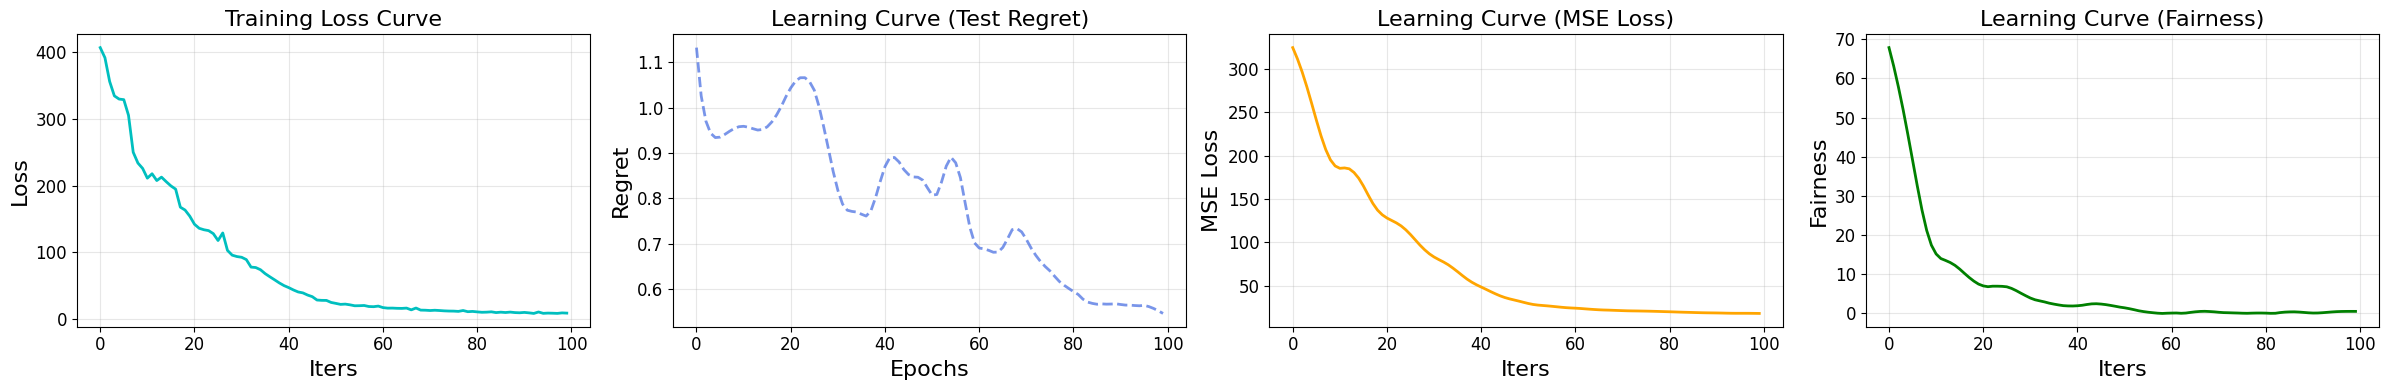

In [7]:
model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, beta=beta, Q=Q,
    lambda_fair=lambdas,
    fairness_type="mad", 
    num_epochs=epochs, lr=lr,
    group=False
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Evaluation

In [8]:
# ------------------------------------------------------------------
#  MULTIPLE-TRIAL TRAINER
# ------------------------------------------------------------------
def train_many_trials(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, beta, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=30, lr=1e-2, batch_size=None,
        n_trials=10, base_seed=2025,group=True,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Run `train_fair_model_logged` for `n_trials` independent seeds and
    return epoch-wise averages of loss, MSE, regret, and fairness.
    """

    # storage: list of dicts, one per trial
    trials_logs = []

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)

        _, logs = train_fair_model_logged(
            X_train, y_train, race_train,
            X_test,  y_test,  race_test,
            cost_test,
            model_class, input_dim,
            alpha, beta, Q,
            lambda_fair=lambda_fair, # type: ignore
            fairness_type=fairness_type,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
            dropout_rate=dropout_rate,
            weight_decay=weight_decay,
            device=device,
            group=group
        )
        trials_logs.append(logs)

    # ---------- epoch-wise aggregation (mean) ----------------------
    keys = ["loss_log", "mse_log", "regret_log", "fairness_log"]
    avg_logs = {}
    for k in keys:
        # some runs may have fairness_log = None when fairness_type="none"
        if trials_logs[0][k] is None:
            avg_logs[k] = None
            continue
        stack = np.vstack([trial[k] for trial in trials_logs])   # shape: (n_trials, num_epochs)
        avg_logs[k] = stack.mean(axis=0).tolist()                # convert back to list for plotting
        std_k = stack.std(axis=0)[-1]                            # std at final epoch
        mean_k = avg_logs[k][-1]
        print(f"[{k.replace('_log','').upper()}]  final-epoch mean = {mean_k:.4f}  |  std = {std_k:.4f}")

    return avg_logs


[LOSS]  final-epoch mean = 18.0365  |  std = 0.6795
[MSE]  final-epoch mean = 18.6258  |  std = 0.4401
[REGRET]  final-epoch mean = 11526294777.8657  |  std = 32669125838.9091
[FAIRNESS]  final-epoch mean = 26.8759  |  std = 0.7038


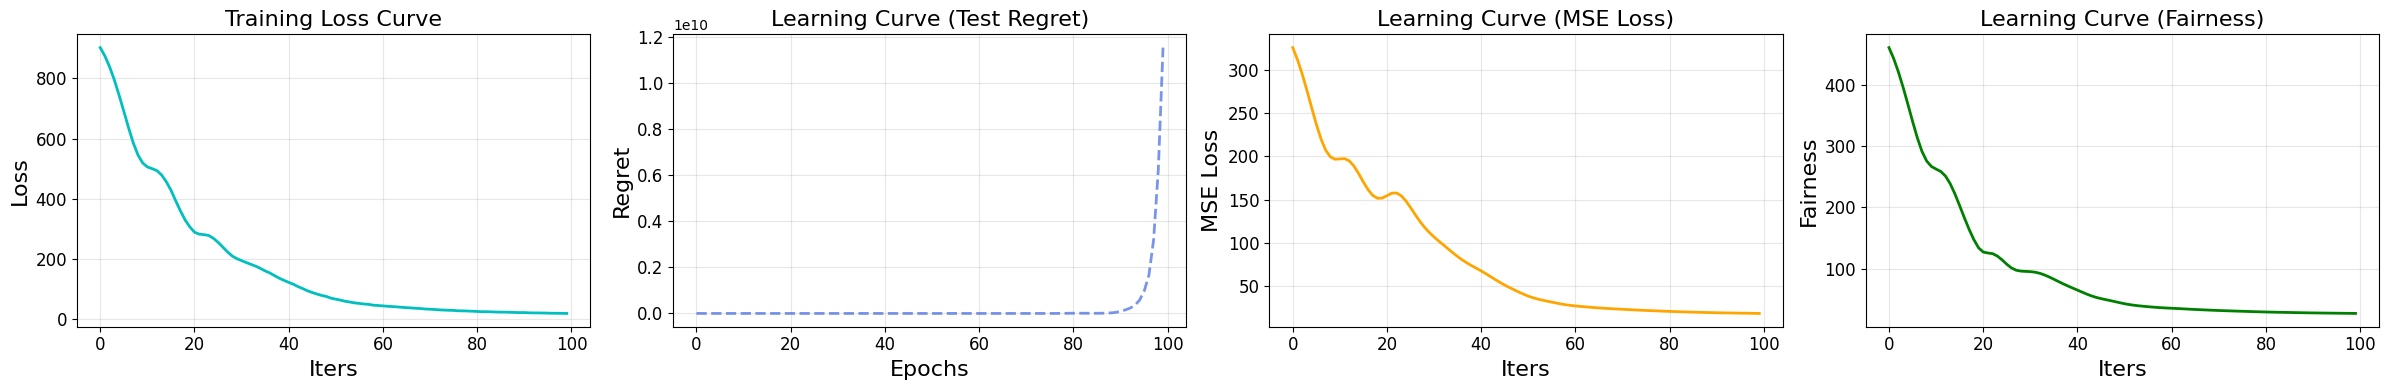

In [9]:
avg_logs = train_many_trials(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, beta=beta, Q=Q,
    lambda_fair=lambdas,
    fairness_type="mad",
    num_epochs=epochs,
    lr=lr,
    n_trials=10,
    group=True
)

# Visualise the averaged learning curves
visLearningCurve(avg_logs["loss_log"],
                 avg_logs["regret_log"],
                 avg_logs["mse_log"],
                 avg_logs["fairness_log"])


In [10]:
alphas = [0.5, 1.5, 2.5]
betas = [0.5, 1.5]  # Only used for group=True
fairness_lambdas = [0, 1]
group_settings = [True, False]

# Store results in a list of dictionaries, suitable for DataFrame conversion
results_list = []

# --- 3. Iterate Through All Parameter Combinations ---
for group in group_settings:
    
    # Define fairness types based on group setting
    fairness_types = ['mad', 'acc_parity', 'atkinson'] if group else ['mad', 'atkinson']
    
    # Iterate through the main parameters
    for lam in fairness_lambdas:
        for fairness in fairness_types:
            # OPTIMIZATION: If lambda is 0, fairness type has no effect.
            # Run this baseline case only once to avoid redundant trials.
            if lam == 0 and fairness != fairness_types[0]:
                continue

            for alpha in alphas:
                # Beta is only relevant for the group=True problem
                current_betas = betas if group else [betas[0]] # Use a single placeholder for individual problem
                
                for beta in current_betas:
                    # The closed-form solution from the previous question has issues with beta=1.
                    # We skip it here to avoid errors during the optimization step.
                    if group and abs(beta - 1.0) < 1e-9:
                        print(f"Skipping: Group=True with beta=1 (requires a different solver formulation).")
                        continue

                    # --- 4. Run a Single Trial Configuration ---
                    run_params = {
                        # CORRECTED: Keys are now capitalized to match the final DataFrame columns
                        'Group': group,
                        'Alpha': alpha,
                        'Beta': beta if group else 'N/A',
                        'Lambda': lam,
                        'Fairness': fairness if lam > 0 else 'None'
                    }
                    print("\n" + "-"*60)
                    print(f"RUNNING TRIAL: {run_params}")
                    print("-"*60)

                    # Run the multi-trial training function with the current parameters
                    # Using fewer epochs/trials for speed during the grid search.
                    # Increase these for your final results.
                    avg_logs = train_many_trials(
                        X_train, y_train, race_train,
                        X_test, y_test, race_test,
                        cost_test,
                        model_class=FairRiskPredictor,
                        input_dim=X_train.shape[1],
                        alpha=alpha, beta=beta, Q=Q,
                        lambda_fair=lam,
                        fairness_type=fairness if lam > 0 else "none",
                        num_epochs=50,  # Reduced for speed
                        lr=0.01,
                        n_trials=10,   # Reduced for speed
                        group=group
                    )

                    # --- 5. Store the Final Results ---
                    final_metrics = run_params.copy()
                    final_metrics['Final Regret'] = avg_logs['regret_log'][-1]
                    final_metrics['Final MSE'] = avg_logs['mse_log'][-1]
                    if avg_logs['fairness_log'] is not None:
                        final_metrics['Final Fairness'] = avg_logs['fairness_log'][-1]
                    else:
                        final_metrics['Final Fairness'] = 0.0 # Use 0 for 'None' type
                    
                    results_list.append(final_metrics)

# --- 6. Present Results in a DataFrame and LaTeX Table ---

# Convert the list of results into a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Reorder columns for clarity
column_order = [
    'Group', 'Alpha', 'Beta', 'Lambda', 'Fairness',
    'Final Regret', 'Final MSE', 'Final Fairness'
]
results_df = results_df[column_order]

# Generate LaTeX table string from the DataFrame
# Using specific column formats and a caption/label for academic papers
latex_table = results_df.to_latex(
    index=False,
    caption="Experimental Results Across Different Fairness and Optimization Parameters.",
    label="tab:exp_results",
    float_format="%.4f",
    column_format="llccccccc"
)

# Display the final outputs
print("\n\n" + "="*80)
print("                           GRID SEARCH COMPLETE")
print("="*80)

print("\n--- Results Summary (Pandas DataFrame) ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(results_df)

print("\n\n" + "="*80)
print("--- LaTeX Table Output ---")
print("You can copy and paste the following code block directly into your .tex file.")
print("="*80)
print(latex_table)


------------------------------------------------------------
RUNNING TRIAL: {'Group': True, 'Alpha': 0.5, 'Beta': 0.5, 'Lambda': 0, 'Fairness': 'None'}
------------------------------------------------------------
[LOSS]  final-epoch mean = 24.6413  |  std = 1.3750
[MSE]  final-epoch mean = 31.4261  |  std = 1.2047
[REGRET]  final-epoch mean = 0.0385  |  std = 0.0026

------------------------------------------------------------
RUNNING TRIAL: {'Group': True, 'Alpha': 0.5, 'Beta': 1.5, 'Lambda': 0, 'Fairness': 'None'}
------------------------------------------------------------
[LOSS]  final-epoch mean = 24.6413  |  std = 1.3750
[MSE]  final-epoch mean = 31.4261  |  std = 1.2047
[REGRET]  final-epoch mean = 0.0655  |  std = 0.0105

------------------------------------------------------------
RUNNING TRIAL: {'Group': True, 'Alpha': 1.5, 'Beta': 0.5, 'Lambda': 0, 'Fairness': 'None'}
------------------------------------------------------------
[LOSS]  final-epoch mean = 24.6413  |  std = 1

In [11]:
results_df

,Group,Alpha,Beta,Lambda,Fairness,Final Regret,Final MSE,Final Fairness
0,True,0.5,0.5,0,None,0.038459,31.426055,0.000000
1,True,0.5,1.5,0,None,0.065544,31.426055,0.000000
2,True,1.5,0.5,0,None,0.043721,31.426055,0.000000
3,True,1.5,1.5,0,None,0.098429,31.426055,0.000000
4,True,2.5,0.5,0,None,0.142279,31.426055,0.000000
5,True,2.5,1.5,0,None,0.350046,31.426055,0.000000
6,True,0.5,0.5,1,mad,0.057505,40.809426,44.297897
7,True,0.5,1.5,1,mad,0.071699,40.809426,44.297897
8,True,1.5,0.5,1,mad,0.069014,40.809426,44.297897
9,True,1.5,1.5,1,mad,0.174353,40.809426,44.297897


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long